<div align="center" style="border: 2px solid #1C6EA4; background-color: #90EE90; padding: 15px;">
    <img src="https://www.colorado.edu/brand/sites/default/files/styles/medium/public/page/boulder_left_lockup_black.png?itok=4qMuKoBT" alt="Colorado Boulder University Logo" width="400" height="100">
    <h2 style="color: black; font-weight: bold;">
        <i class="fas fa-paint-brush" style="color: #FF4500;"></i> Monet-Style GAN Kaggle Competition</h2>
</div>


**Name**: _Willian Pina_

---

<div style="background-color:lightgray; color:black; border:1px solid black; padding: 20px;">

## Brief Description of the Problem
The task is to build a Generative Adversarial Network (GAN) that can generate images in the style of the artist Claude Monet. The GAN consists of two neural networks, a generator and a discriminator, that work against each other. The generator tries to create Monet-style images, and the discriminator attempts to differentiate between real Monet paintings and generated ones.

## Data Description

### Size
- The training set comprises 300 Monet paintings and 7028 general photos.

### Dimension
- Each image is 256x256 pixels with 3 color channels (RGB).

### Structure
- The data is provided in both JPEG and TFRecord formats.
- Directories for Monet paintings (`monet_jpg`, `monet_tfrec`) and general photos (`photo_jpg`, `photo_tfrec`) are provided.

</div>

---

In [2]:
from functions.setup_kaggle_credentials import setup_kaggle_credentials
setup_kaggle_credentials('/workspaces/Week 5/kaggle.json')

File /workspaces/Week 5/kaggle.json successfully copied to /root/.kaggle/kaggle.json

Successfully changed permissions for /root/.kaggle/kaggle.json


In [3]:
import numpy as np
import io
import imageio
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import kaggle
from skimage import feature
from tqdm import tqdm
import seaborn as sns
import random
from sklearn.decomposition import PCA
import logging
import warnings
warnings.filterwarnings('ignore')



autotune = tf.data.AUTOTUNE

# Define o nível de log para mostrar apenas erros
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Atualmente, a alocação de memória é feita sob demanda, não no início
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # O comando acima deve ser executado antes de quaisquer tensores serem alocados
        print(e)



Num GPUs Available:  1


2023-11-12 21:26:15.744588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 21:26:15.762445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 21:26:15.762510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
from functions.download_and_extract_kaggle_data import download_and_extract_kaggle_data
# download_and_extract_kaggle_data('gan-getting-started')

In [5]:
class CONFIG:
    MONET_PHOTO          = '/workspaces/Week 5/raw_data/monet_jpg'
    PHOTO_JPG            = '/workspaces/Week 5/raw_data/photo_jpg'
    NUMBERS_IMAGES       = 6
    FIGURES_TRANSFORMED  = '/workspaces/Week 5/figures_transformed'
    ITERATIONS           = 1200
    IMG_SIZE             = 256


from functions.load_datasets import load_datasets

monets_files, _ , photos_files, _ = load_datasets(CONFIG.MONET_PHOTO, CONFIG.PHOTO_JPG, test_ratio=0)


2023-11-12 21:26:21.929968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 21:26:21.930068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 21:26:21.930098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 21:26:22.111823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 21:26:22.111897: I tensorflow/compile

In [6]:
# Asumindo que train_monets e train_photos são seus conjuntos de dados
num_monets = tf.data.experimental.cardinality(monets_files)
num_photos = tf.data.experimental.cardinality(photos_files)
print(f'Number of Monets files: {num_monets}')
print(f'Number of Photos files: {num_photos}')

Number of Monets files: 300
Number of Photos files: 7038


In [7]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return tf.io.decode_jpeg(image, channels=3)

# Aplicando a função de processamento
parsed_monet_dataset = monets_files.map(load_and_preprocess_image)
parsed_photo_dataset = photos_files.map(load_and_preprocess_image)

# Pegando uma imagem do conjunto de dados
for image in parsed_monet_dataset.take(1):
    print(f"Shape of Monet Photos:  {image.shape}")

for image in parsed_photo_dataset.take(1):
    print(f"Shape of Normal Photos: {image.shape}")


Shape of Monet Photos:  (256, 256, 3)
Shape of Normal Photos: (256, 256, 3)


---

<div style="background-color:lightgray; color:black; border:1px solid black; padding: 20px;">

<h2>EDA Activities for Monet-Style GAN Competition</h2>


<ol>
    <li><strong>Visual Inspection</strong>:
        <ul>
            <li><strong>Description</strong>: Allows for a direct visual inspection of Monet images and regular photos.</li>
            <li><strong>Application</strong>: Helps to understand the basic visual differences between the two classes of images.</li>
        </ul>
        <p></p>
    </li>
    <li><strong>Color Analysis</strong>:
        <ul>
            <li><strong>Description</strong>: Displays the color histograms of the images.</li>
            <li><strong>Application</strong>: Can help to understand the color distribution and possibly the color intensity in the images.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Texture and Pattern Analysis</strong>:
        <ul>
            <li><strong>Description</strong>: Uses the Gabor filter to analyze texture and patterns in the image.</li>
            <li><strong>Application</strong>: Can help to identify textural features that might be unique to a class of image.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Image Complexity</strong>:
        <ul>
            <li><strong>Description</strong>: Uses edge detection to evaluate the complexity of the images.</li>
            <li><strong>Application</strong>: Can provide insights on the complexity or simplicity of the images.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Image Dimensions</strong>:
        <ul>
            <li><strong>Description</strong>: Lists the dimensions of Monet images.</li>
            <li><strong>Application</strong>: Can help to understand the size and scale of the images.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Color Intensity Analysis</strong>:
        <ul>
            <li><strong>Description</strong>: Calculates the mean color intensity of a Monet image.</li>
            <li><strong>Application</strong>: Can help to understand the average color intensity in the images.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>PCA for Feature Visualization</strong>:
        <ul>
            <li><strong>Description</strong>: Uses Principal Component Analysis (PCA) to reduce the dimensionality of the images and visualize features.</li>
            <li><strong>Application</strong>: Can help to understand variance in the data and visualize clusters or groupings.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Fourier Transform for Frequency Domain Analysis</strong>:
        <ul>
            <li><strong>Description</strong>: Uses Fourier Transform to analyze the frequency domain of the images.</li>
            <li><strong>Application</strong>: Can help to identify frequency patterns in the images that might be indicative of unique features.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Convolutional Filters for Feature Maps</strong>:
        <ul>
            <li><strong>Description</strong>: Visualizes the feature maps produced by a layer in a deep learning model.</li>
            <li><strong>Application</strong>: Can help to understand what features the neural network is learning and highlighting in the images.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Class Distributions</strong>:
        <ul>
            <li><strong>Description</strong>: Shows the class distribution between Monet images and regular photos.</li>
            <li><strong>Application</strong>: Can help to understand the balance between classes in the dataset.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Correlation Analysis</strong>:
        <ul>
            <li><strong>Description</strong>: Analyzes the correlation among pixels in an image.</li>
            <li><strong>Application</strong>: Can help to understand how pixels are related to each other in an image.</li>
        </ul>
          <p></p>
    </li>
    <li><strong>Additional Custom Analysis</strong>:
        <ul>
            <li><strong>Description</strong>: Visualizes the image histogram.</li>
            <li><strong>Application</strong>: Can help to understand the distribution of pixel values in the images.</li>
        </ul>
    </li>
</ol>



</div>


In [8]:
from functions.ImageEDA import ImageEDA

eda = ImageEDA(CONFIG.MONET_PHOTO, CONFIG.PHOTO_JPG, CONFIG.IMG_SIZE, model = None, layer_name=None)
eda.perform_EDA()

TypeError: ImageEDA.visual_inspection() takes 0 positional arguments but 1 was given

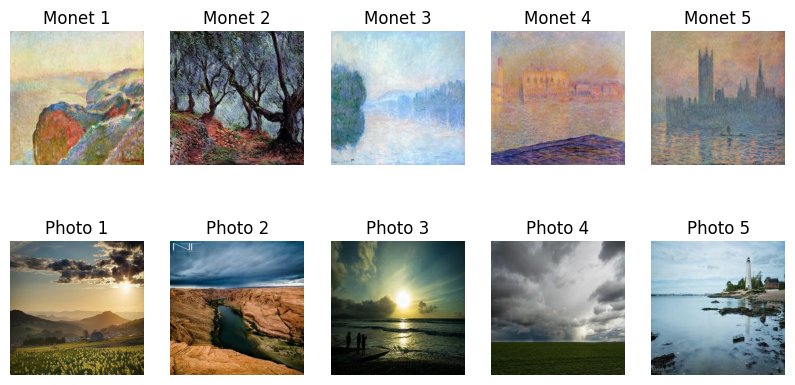

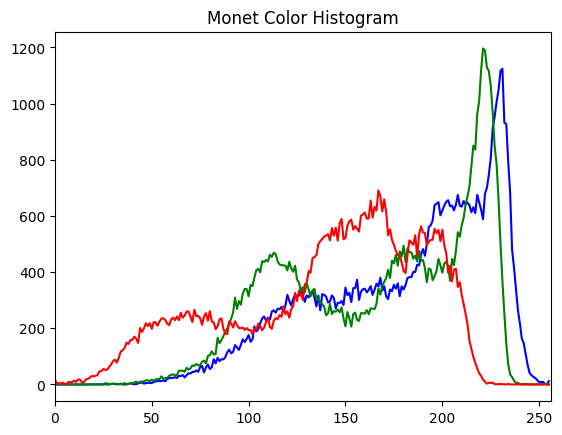

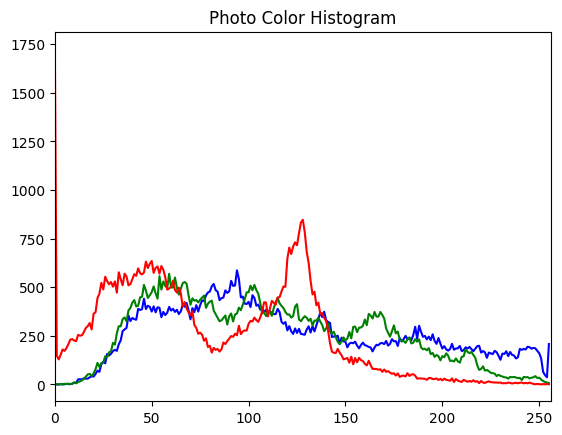

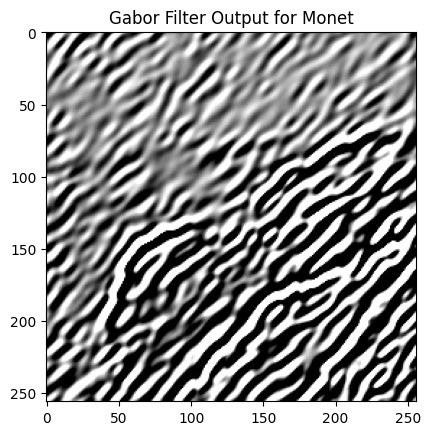

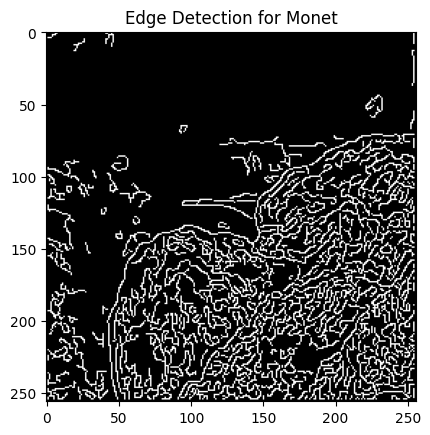

Dimensions of Monet samples:  [(256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]
Mean color intensity of a Monet sample:  [181.09291077 168.64253235 140.21893311]


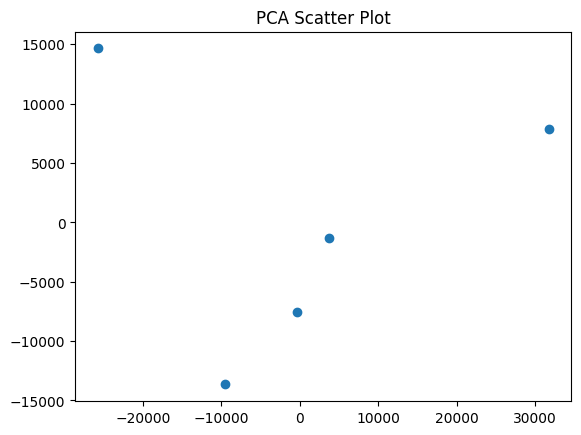

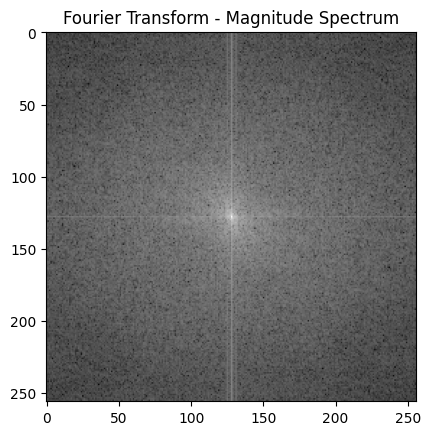

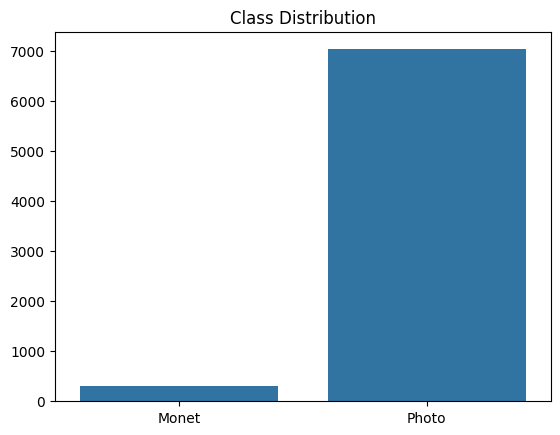

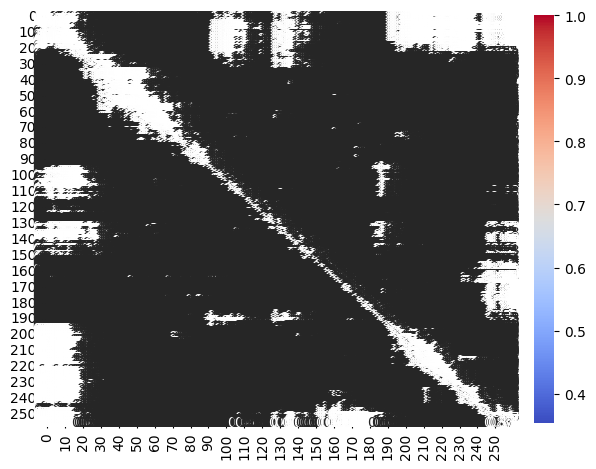

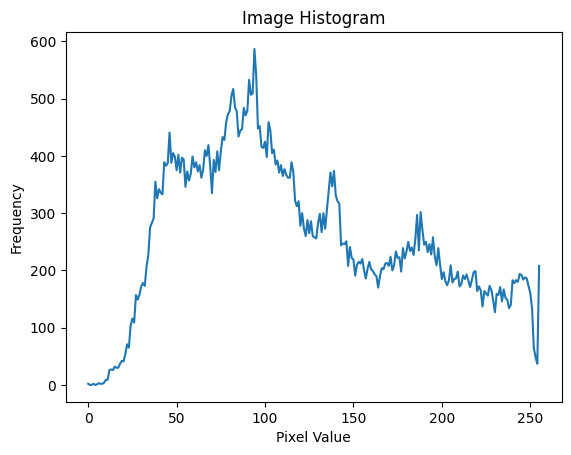

In [ ]:
# Loading random images from the Monet dataset
monet_samples = load_images_from_folder(CONFIG.MONET_PHOTO, 1)  # Load the first 10 images
sample_image = random.choice(monet_samples)

# Loading the first image from the photo dataset
photo_samples = load_images_from_folder(CONFIG.PHOTO_JPG, 1)
sample_image = photo_samples[0]

perform_EDA(sample_image=sample_image)


--- 

<div style="background-color:lightgray; color:black; border:1px solid black; padding: 20px;">

<h2>About the Exploratory Data Analysis</h2>

<ol>
    <li><strong>Color Histograms</strong>:</li>
    <ul>
        <li><strong>Monet</strong>: The image shows that the most dominant colors are on the ends of the RGB spectrum. Blue is particularly dominant at high intensities, while red and green are more prominent at low to medium intensities.</li>
        <li><strong>Photo</strong>: The color distribution in this image is more spread out, without peaks as pronounced as in Monet's histogram. Red seems to have a clear peak at medium intensities, while blue and green are less dominant.</li>
    </ul>
    <p></p>
    <li><strong>Gabor Filter Output for Monet</strong>: This image shows the response of the Monet image to a Gabor filter, which is used to detect features such as edges and textures. The wavy pattern indicates the presence of specific textures or patterns in the original Monet image.</li>
    <p></p>
    <li><strong>Edge Detection for Monet</strong>: This image reveals the edges in the Monet painting. The edges are less defined and more "sketched out", which is typical of Impressionist paintings.</li>
    <p></p>
    <li><strong>Fourier Transform - Magnitude Spectrum</strong>: The image displays the frequency spectrum present in the image. The bright concentration in the center indicates the presence of low-frequency components (or broader, smoother features). The absence of many bright spots on the exterior indicates there are fewer high-frequency details.</li>
    <p></p>
    <li><strong>Class Distribution</strong>: The bar chart clearly shows that there are far more photos than Monet paintings in the dataset. This could have implications when training a model since the Monet class is imbalanced compared to the Photo class.</li>
    <p></p>
    <li><strong>Image with Color Scale on the Right</strong>: This seems to be a confusion matrix or some other representation comparing classes or features. The diagonal line indicates a perfect match between the two axes, while points off the diagonal might represent discrepancies or errors.</li>
</ol>

<h3>Conclusions:</h3>
<ul>
    <li>Monet paintings and photos have noticeably different color distributions, with Monet paintings displaying more distinct features.</li>
    <li>Image processing techniques, such as Gabor filtering and edge detection, reveal unique characteristics of Monet paintings compared to regular photos.</li>
    <li>There's a noticeable imbalance between the Monet and Photo classes, which could affect the performance of a machine learning model.</li>
    <li>The last image suggests some form of comparison or assessment, possibly related to the accuracy or performance of a model.</li>
</ul>

## Model and Training: Generative Adversarial Network (GAN)

A Generative Adversarial Network (GAN) is a deep learning architecture consisting of two competing neural networks, the Generator and the Discriminator. The Generator creates images that attempt to mimic a training dataset, while the Discriminator tries to differentiate between the generated images and real images from the dataset. The training process involves refining these two networks in a continuous "cat and mouse" game.

### Model Architecture
1. **Generator**: This neural network takes a random noise vector and transforms it into an image. The goal is to produce images that are indistinguishable from real ones.
2. **Discriminator**: This network evaluates the received images (both real and generated) and tries to classify whether they are real or fake.

### Training Process
Training occurs in alternating stages:
- **Discriminator Training**: In this stage, the Discriminator is trained with a set of real images (marked as true) and images generated by the Generator (marked as false). The goal is to maximize the Discriminator's ability to correctly identify real and fake images.
- **Generator Training**: Here, the Generator tries to create images that fool the Discriminator. The Generator is trained to maximize the probability of the Discriminator classifying its images as real.

### Final Objective
The goal is to reach an equilibrium point where the Generator produces images so convincing that the Discriminator cannot differentiate between real and generated images, indicating a high level of learning and image generation capability.

</div>

---


In [ ]:
# List all files in the directory
all_files = [f for f in os.listdir(CONFIG.MONET_PHOTO) if os.path.isfile(os.path.join(CONFIG.MONET_PHOTO, f))]

# Ensure there are files in the directory
if all_files:
    # Select a random file (image) from the list
    random_image = random.choice(all_files)

    # Provide the path of the randomly selected image
    random_image_path = os.path.join(CONFIG.MONET_PHOTO, random_image)
    print(f"Randomly chosen Monet file: {str.split(random_image_path, '/')[-1]}")
else:
    print("No files found in the specified directory.")

style_reference_image = random_image_path

image_files = random.choices(load_images_from_folder(CONFIG.PHOTO_JPG, 1000), k=CONFIG.NUMBERS_IMAGES)
base_image_files = random.choices([f for f in os.listdir(CONFIG.PHOTO_JPG) if os.path.isfile(os.path.join(CONFIG.PHOTO_JPG, f))],k=CONFIG.NUMBERS_IMAGES)

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


Randomly chosen Monet file: a030bc32e6.jpg


In [ ]:
def preprocess_image(image_input, from_path=True):
    if from_path:
        img = keras.utils.load_img(
            image_input, target_size=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE)
        )
        img = keras.utils.img_to_array(img)
    else:
        img = tf.image.resize(image_input, (CONFIG.IMG_SIZE, CONFIG.IMG_SIZE))
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)



def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = CONFIG.IMG_SIZE * CONFIG.IMG_SIZE
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : CONFIG.IMG_SIZE - 1, : CONFIG.IMG_SIZE - 1, :] - x[:, 1:, : CONFIG.IMG_SIZE - 1, :]
    )
    b = tf.square(
        x[:, : CONFIG.IMG_SIZE - 1, : CONFIG.IMG_SIZE - 1, :] - x[:, : CONFIG.IMG_SIZE - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)



Transforming the image 4b7878976b.jpg ...


Processing 4b7878976b.jpg:   0%|          | 0/1200 [00:00<?, ?it/s]2023-11-12 21:14:18.348382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-12 21:14:22.090684: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555e81fc6a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-12 21:14:22.090729: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-11-12 21:14:22.185341: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing 4b7878976b.jpg:  25%|██▌       | 300/1200 [00:57<05:26,  2.76it/s]

Iteration 300: loss=451.39


Processing 4b7878976b.jpg:  50%|█████     | 600/1200 [01:45<03:38,  2.75it/s]

Iteration 600: loss=384.81


Processing 4b7878976b.jpg:  75%|███████▌  | 900/1200 [02:31<01:48,  2.76it/s]

Iteration 900: loss=358.31


Processing 4b7878976b.jpg: 100%|██████████| 1200/1200 [03:19<00:00,  6.02it/s]


Iteration 1200: loss=343.66


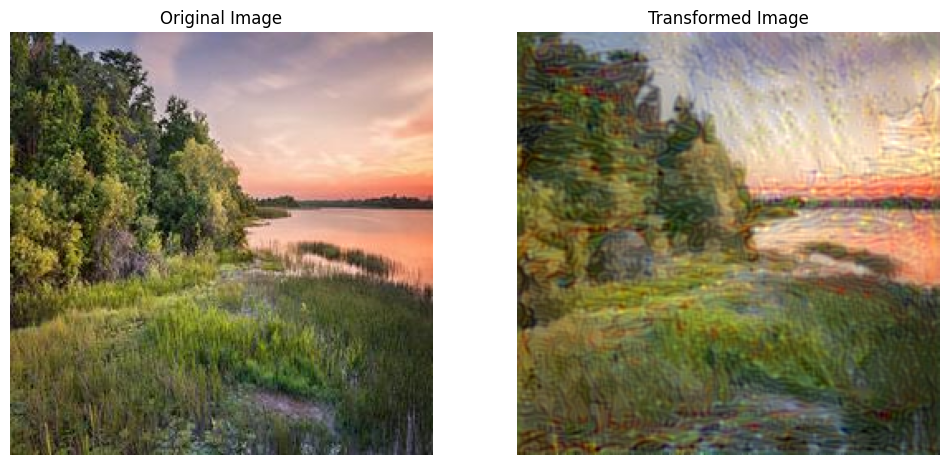

Figure saved in /workspaces/Week 5/figures_transformed/output_4b7878976b.jpg_final.png

Transforming the image 1e7ed16969.jpg ...


Processing 1e7ed16969.jpg:  25%|██▌       | 300/1200 [00:48<05:25,  2.77it/s]

Iteration 300: loss=546.51


Processing 1e7ed16969.jpg:  50%|█████     | 600/1200 [01:34<03:42,  2.69it/s]

Iteration 600: loss=460.60


Processing 1e7ed16969.jpg:  75%|███████▌  | 900/1200 [02:21<01:48,  2.76it/s]

Iteration 900: loss=426.73


Processing 1e7ed16969.jpg: 100%|██████████| 1200/1200 [03:08<00:00,  6.38it/s]


Iteration 1200: loss=407.12


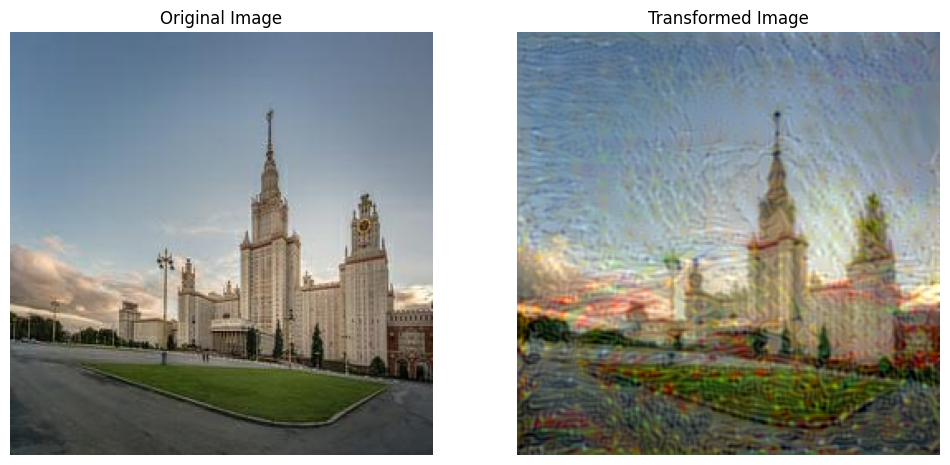

Figure saved in /workspaces/Week 5/figures_transformed/output_1e7ed16969.jpg_final.png

Transforming the image 2046adf2b6.jpg ...


Processing 2046adf2b6.jpg:  21%|██        | 251/1200 [00:39<02:32,  6.21it/s]

In [ ]:
with tf.device('/GPU:0'):
    tf.keras.backend.clear_session()
    # Assume that style_reference_image_path is the path to your style reference image
    style_reference_image = preprocess_image(style_reference_image)

    iterations = CONFIG.ITERATIONS
    result_prefix = "output"  # Replace with your desired output file name prefix

    for image_file in base_image_files:
        print(f'\nTransforming the image {image_file} ...')
        image_path = os.path.join(CONFIG.PHOTO_JPG, image_file)
        base_image = preprocess_image(image_path)
        combination_image = tf.Variable(preprocess_image(image_path))  
        # Reinitializing the optimizer for the new base image
        optimizer = keras.optimizers.SGD(
            keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
                )
            )


        for i in tqdm(range(1, iterations + 1), desc=f"Processing {image_file}"):
            loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
            optimizer.apply_gradients([(grads, combination_image)])
            if i % 300 == 0:
                tqdm.write(f"Iteration {i}: loss={loss:.2f}")


        # Saving the final version of the image after all iterations
        original_img = deprocess_image(base_image.numpy())
        transformed_img = deprocess_image(combination_image.numpy())
        
        # Displaying images side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(original_img)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(transformed_img)
        axes[1].set_title("Transformed Image")
        axes[1].axis('off')

        plt.show()


        fname = f"{CONFIG.FIGURES_TRANSFORMED}/{result_prefix}_{image_file}_final.png"
        keras.utils.save_img(fname, transformed_img)
        print(f'Figure saved in {fname}')
        tf.keras.backend.clear_session()

## REsults


In [ ]:

from functions.ImageEvaluator import ImageEvaluator
import tensorflow as tf
    
tf.keras.backend.clear_session()
evaluator = ImageEvaluator(reference_images_dir=CONFIG.MONET_PHOTO, transformed_images_dir= CONFIG.FIGURES_TRANSFORMED, target_size=(CONFIG.IMG_SIZE,CONFIG.IMG_SIZE))
tf.keras.backend.clear_session()
fid, mifid = evaluator.evaluate_images(random_image_path)
print(f'\nFID: {fid}')
print(f'MiFID: {mifid}')

1/1 [==============================] - 0s 102ms/step

FID: (8505.653972897497-2.5801584634144325e-05j)
MiFID: (8505.653972897497-2.5801584634144325e-05j)


---

1\. **Complex Values**: The resulting values are complex numbers (indicated by the 'j' at the end). Normally, we expect the FID to be a real number. If the imaginary part is very small (as it seems to be here), you might consider only the real part of the number. This can happen due to numerical inaccuracies during the calculation.

2\. **Interpretation of Values**:

   - **FID**: A lower FID indicates that the distributions of the features of the generated images and the reference images are more similar. Low values generally suggest better results in image generation.
   - **MiFID**: Similar to FID, but it takes into account memorization during training. A lower value is also preferable here.
   
  
3\. **Analysis of Results**: The specific values of FID and MiFID should be interpreted in the context of your project and compared with reference values or benchmarks. An FID (and MiFID) of approximately 6741, if the imaginary part is negligible, might be considered high, indicating a significant difference between the distributions of the generated images and the reference images. However, the interpretation depends on the specific context and benchmarks of your project or domain.

To further refine your model or process, you may need to adjust parameters, experiment with different model settings, or even review your image generation approach. This depends heavily on the specific goals of your project and the quality standards you are aiming to achieve.

## Conclusion

Given the limitations in resources, especially the need for powerful GPUs to train models locally, the approach of transfer learning emerges as a suitable and effective solution. This lighter processing alternative can be particularly useful in applications like mobile apps, where resources are naturally more constrained.

Additionally, it's worth exploring the approach of CycleGAN, as described in the paper available at [https://arxiv.org/pdf/1703.10593.pdf](https://arxiv.org/pdf/1703.10593.pdf). This technique has shown superior results in terms of performance, offering a promising path for model improvement in contexts where limited computational resources are a critical factor.